In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

2025-01-06 13:17:09.730425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 13:17:10.045439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 13:17:10.045490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 13:17:10.047240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 13:17:10.201119: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 13:17:10.203481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
target_dir = '../Dataset'
model_weights_directory = '../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cv_patient_resnet_multi'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [3]:
model_dirs

['../logs/cv_patient_resnet_multi_8fold_0_20241129-104226/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_0_20241129-104811/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_1_20241129-105017/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_2_20241129-105230/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_3_20241129-105445/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_4_20241129-105654/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_5_20241129-105846/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_6_20241129-110043/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_7_20241129-110235/weights.h5']

In [4]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('configs/test_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [5]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class

metrics = []
y_true_ordinals = []
y_pred_ordinals = []
split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)
for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have
    model = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    print(y_pred)
    print(y_pred_ordinal)
    print(y_pred_one_hot)
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

1/1 [==============================] - 2s 2s/step
[[0.6814903  0.23001263 0.0884971 ]
 [0.37031862 0.21504873 0.41463265]
 [0.30565095 0.36723742 0.32711166]
 [0.41866398 0.28962842 0.29170755]
 [0.35279182 0.26186857 0.38533956]
 [0.54529667 0.124169   0.33053422]
 [0.1799092  0.4831597  0.3369311 ]
 [0.11414281 0.59244215 0.29341504]
 [0.01243693 0.06303056 0.92453253]
 [0.17905015 0.47388145 0.3470683 ]
 [0.6385943  0.20238332 0.15902232]]
[0 2 1 0 2 0 1 1 2 1 0]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
1/1 [==============================] - 2s 2s/step
[[0.13542907 0.12802121 0.7365497 ]
 [0.04407442 0.6515389  0.30438665]
 [0.30198994 0.14180627 0.5562038 ]
 [0.42853668 0.04676053 0.52470285]
 [0.83849347 0.01186642 0.14964007]
 [0.04902672 0.08777362 0.8631997 ]
 [0.04352221 0.02535865 0.9311192 ]
 [0.0455401  0.343513   0.61094683]
 [0.05063163 0.32104957 0.6283187 ]
 [0.2961651  0.2562675

/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 2s 2s/step
[[0.4127622  0.06744217 0.51979566]
 [0.2003857  0.13820367 0.6614106 ]
 [0.21655348 0.21720608 0.5662404 ]
 [0.44372663 0.09822103 0.4580523 ]
 [0.3019857  0.27636442 0.42164996]
 [0.75843316 0.03745886 0.2041079 ]
 [0.00307269 0.04190975 0.95501757]
 [0.7994058  0.10435142 0.09624277]
 [0.46053964 0.20534462 0.33411568]
 [0.07518394 0.3542173  0.5705988 ]
 [0.13020676 0.43464503 0.4351482 ]
 [0.0794341  0.56367266 0.35689327]
 [0.12263852 0.16354549 0.7138159 ]
 [0.09603535 0.15232964 0.7516351 ]]
[2 2 2 2 2 0 2 0 0 2 2 1 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 [==============================] - 2s 2s/step
[[0.32562616 0.38695025 0.28742352]
 [0.70907295 0.18297014 0.10795683]
 [0.35822034 0.48341453 0.15836512]
 [0.2709154  0.35438097 0.3747036 ]
 [0.71968913 0.02300468 0.25730607]
 [0.09708704 0.6

/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 2s 2s/step
[[0.28061235 0.4631179  0.25626987]
 [0.71974087 0.14588596 0.13437308]
 [0.49468133 0.35606724 0.14925149]
 [0.8637381  0.02848254 0.10777931]
 [0.76852155 0.1033735  0.128105  ]
 [0.744327   0.16596933 0.08970375]
 [0.97287893 0.0100134  0.01710764]
 [0.13626051 0.51957107 0.3441684 ]
 [0.36136964 0.37468457 0.26394582]
 [0.17922263 0.5889935  0.23178388]
 [0.46724832 0.39788866 0.13486299]
 [0.9689599  0.00323589 0.02780423]
 [0.66683066 0.23630781 0.09686149]]
[1 0 0 0 0 0 0 1 1 1 0 0 0]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 1s 1s/step
[[0.07308223 0.10395064 0.82296723]
 [0.09373637 0.06354701 0.8427166 ]
 [0.03973711 0.1920107  0.76825213]
 [0.00370915 0.13581234 0.86047834]
 [0.04552764 0.14458373 0.80988854]
 [0.32838836 0.05921562 0.6123961 ]
 [0.01805976 0.17688867 0.8050516 ]
 [0.01984774 0.09604877 0.8841034 ]
 [0.18527824 0.03500706 0.7797147 ]
 [0.0989885  0.12189535 0.77911615]]
[2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 1s 1s/step
[[0.01139411 0.08104357 0.9075624 ]
 [0.06182783 0.2662188  0.6719533 ]
 [0.04174807 0.16189107 0.7963609 ]
 [0.00927902 0.14466953 0.8460514 ]
 [0.01086028 0.41946113 0.56967866]
 [0.0425051  0.07142622 0.88606864]
 [0.00276051 0.06304959 0.9341899 ]
 [0.01101436 0.32905427 0.6599315 ]
 [0.04039422 0.11267682 0.846929  ]
 [0.00935026 0.2755738  0.7150759 ]
 [0.02106738 0.17727056 0.8016621 ]
 [0.00581915 0.2152688  0.77891207]]
[2 2 2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


In [6]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics], dtype=object)

/tmp/ipykernel_16589/4237036052.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])


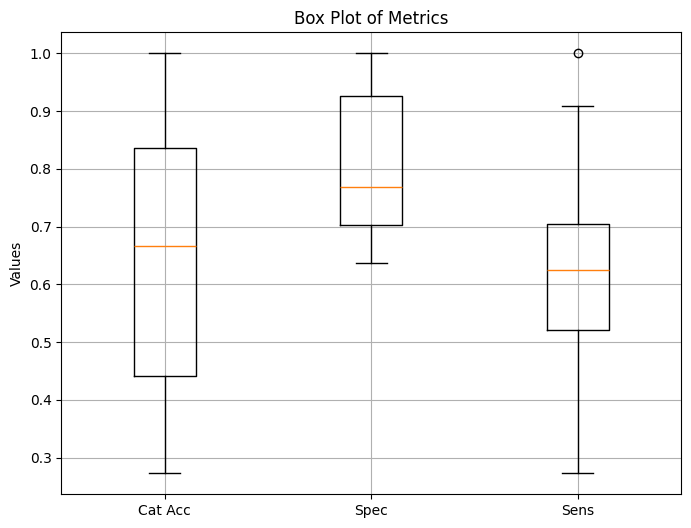

In [7]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [8]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('configs/test_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [9]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
for i, patient_id in enumerate(patient_ids):
    print(patient_id)
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_pred_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

PT004
PT005
PT006
PT009
PT016
PT020
PT021
PT022


/tmp/ipykernel_16589/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_16589/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_16589/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [10]:
eggim_df

,eggim_square,eggim_global,eggim_pred
PT004,1.0,1.0,3.0
PT005,4.0,3.0,8.0
PT006,1.0,1.0,5.0
PT009,8.0,8.5,7.0
PT016,0.0,0.0,4.5
PT020,1.0,2.0,2.0
PT021,10.0,10.0,10.0
PT022,8.0,8.0,10.0


In [11]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [12]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [13]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [14]:
patch_eggim_mae

2.3125

In [15]:
# patch ground truth vs patch pred:
patch_eggim_mae

2.3125

In [16]:
# global ground truth vs patch pred
patch_global_eggim_mae

2.375

In [17]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae

2.0625

In [18]:
best_possible_eggim_mae

0.3125